***AI-Driven Financial Forecasting and Valuation: A Comparative Study of Major Indian Banks***

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of bank tickers
tickers = {
    'HDFC': 'HDB',
    'State Bank of India': 'SBIN.NS',
    'ICICI Bank': 'ICICIBANK.NS',
    'Axis Bank': 'AXISBANK.NS',
    'Kotak Mahindra Bank': 'KOTAKBANK.NS',
    'IndusInd Bank': 'INDUSINDBK.NS',
    'Yes Bank': 'YESBANK.NS',
    'Punjab National Bank': 'PNB.NS'
}

data_dict = {}

for bank, ticker in tickers.items():
    # Fetch historical data
    stock = yf.Ticker(ticker)
    hist_data = stock.history(period='10y')

    # Preprocess data
    hist_data = hist_data[['Close']]  # Use closing prices as a proxy
    hist_data = hist_data.pct_change().dropna()  # Calculate daily returns and drop NaN values
    normalized_data = (hist_data - hist_data.mean()) / hist_data.std()

    # Split into training and test sets
    train_data = normalized_data[:int(0.8*len(hist_data))]
    test_data = normalized_data[int(0.8*len(hist_data)):]

    data_dict[bank] = {
        'hist_data': hist_data,
        'normalized_data': normalized_data,
        'train_data': train_data,
        'test_data': test_data
    }

# Display data for one bank as example
print(data_dict['HDFC']['hist_data'].head())


                              Close
Date                               
2014-07-15 00:00:00-04:00  0.009408
2014-07-16 00:00:00-04:00  0.018429
2014-07-17 00:00:00-04:00 -0.016431
2014-07-18 00:00:00-04:00  0.020935
2014-07-21 00:00:00-04:00 -0.014706


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential

def build_gan(input_dim, data_dim):
    # Generator model
    generator = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(data_dim, activation='tanh')
    ])

    # Discriminator model
    discriminator = Sequential([
        Dense(512, input_dim=data_dim),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])

    # Compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Compile GAN
    gan = Sequential([generator, discriminator])
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer='adam')

    return gan, generator, discriminator

gan_dict = {}
for bank in tickers.keys():
    data_dim = data_dict[bank]['train_data'].shape[1]
    gan, generator, discriminator = build_gan(100, data_dim)
    gan_dict[bank] = {
        'gan': gan,
        'generator': generator,
        'discriminator': discriminator
    }

# Training the GAN for one bank as example
epochs = 10000
batch_size = 32
bank = 'HDFC'
train_data = data_dict[bank]['train_data'].values
gan, generator, discriminator = gan_dict[bank]['gan'], gan_dict[bank]['generator'], gan_dict[bank]['discriminator']

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, train_data.shape[0], batch_size)
    real_data = train_data[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Epoch: 6000, D Loss: 0.6259743273258209, G Loss: 0.7753088474273682
1/1 [==============================] - 0s 33ms/step
Epoch: 7000, D Loss: 0.5951424241065979, G Loss: 0.7895411849021912
1/1 [==============================] - 0s 24ms/step
Epoch: 8000, D Loss: 0.6189264953136444, G Loss: 0.800386905670166
1/1 [==============================] - 0s 23ms/step
Epoch: 9000, D Loss: 0.6398390829563141, G Loss: 0.7284142971038818
1/1 [==============================] - 0s 34ms/step


In [3]:
generated_data_dict = {}

for bank in tickers.keys():
    generator = gan_dict[bank]['generator']
    num_scenarios = 1000
    latent_space_samples = np.random.normal(0, 1, (num_scenarios, 100))
    generated_data = generator.predict(latent_space_samples)

    # Convert generated data to original scale
    hist_data = data_dict[bank]['hist_data']
    generated_data = generated_data * hist_data.std().values + hist_data.mean().values

    generated_data_dict[bank] = pd.DataFrame(generated_data, columns=['Close'])

# Display generated data for one bank as example
print(generated_data_dict['HDFC'].head())


32/32 [==============================] - 0s 3ms/step
      Close
0  0.017219
1  0.008561
2 -0.015840
3 -0.003114
4  0.011743


In [4]:
# For simplicity, assume FCF as a percentage of 'Close' prices
fcf_percentage = 0.05  # Example percentage

npv_dict = {}
sensitivity_dict = {}

for bank in tickers.keys():
    forecasted_fcf = generated_data_dict[bank]['Close'] * fcf_percentage

    # DCF Valuation
    discount_rate = 0.1  # Example WACC
    fcf_pv = [fcf / (1 + discount_rate)**i for i, fcf in enumerate(forecasted_fcf, start=1)]
    npv = np.sum(fcf_pv)

    # Sensitivity Analysis
    sensitivity = {}
    for rate in np.arange(0.08, 0.12, 0.01):
        fcf_pv = [fcf / (1 + rate)**i for i, fcf in enumerate(forecasted_fcf, start=1)]
        sensitivity[rate] = np.sum(fcf_pv)

    npv_dict[bank] = npv
    sensitivity_dict[bank] = sensitivity

# Output results for one bank as example
print(f"Base NPV for HDFC: {npv_dict['HDFC']}")
print("Sensitivity Analysis for HDFC:", sensitivity_dict['HDFC'])


Base NPV for HDFC: 0.0003354375974120269
Sensitivity Analysis for HDFC: {0.08: 0.000372412041206242, 0.09: 0.0003480281097314444, 0.09999999999999999: 0.0003354375974120269, 0.10999999999999999: 0.0003310234053865831}


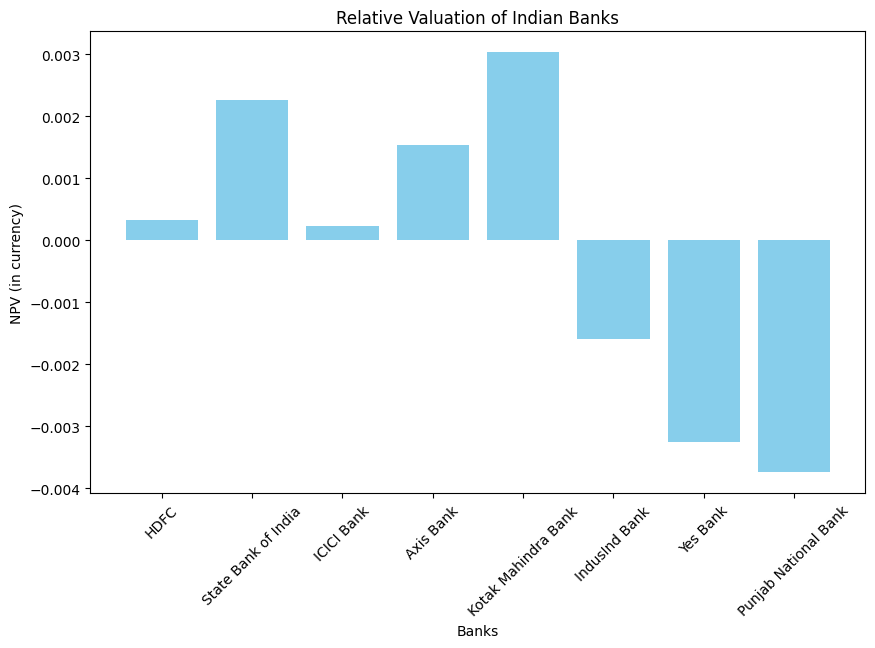

The best investment option is: Kotak Mahindra Bank


In [5]:
import matplotlib.pyplot as plt

# Plot NPVs for all banks
banks = list(npv_dict.keys())
npvs = list(npv_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(banks, npvs, color='skyblue')
plt.xlabel('Banks')
plt.ylabel('NPV (in currency)')
plt.title('Relative Valuation of Indian Banks')
plt.xticks(rotation=45)
plt.show()

# Output the best investment option
best_investment = max(npv_dict, key=npv_dict.get)
print(f"The best investment option is: {best_investment}")
